<a href="https://colab.research.google.com/github/Noxem-droid/Python-neural-network/blob/WiP/DigitRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf

import os
import cv2
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt

dataset = tf.keras.datasets.mnist

(train_i, train_l), (test_i, test_l) = dataset.load_data()

train_i = tf.keras.utils.normalize(train_i, axis=1)
test_i = tf.keras.utils.normalize(test_i, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_i, train_l, epochs=5)

model.save('handwrittenRecognition.keras')

model = tf.keras.models.load_model('handwrittenRecognition.keras')
loss, accuracy = model.evaluate(test_i, test_l)

print("Loss : ", loss)
print("Accuracy : ", accuracy)

image_number = 1
while os.path.isfile(f"digit/digit{image_number}.png"):
    try:
        img = cv2.imread(f"digit/digit{image_number}.png")[:,:,0]
        img = np.invert(np.array([img]))
        prediction = model.predict(img)
        print("The number is probably a {}".format(np.argmax(prediction)))
        plt.imshow(img[0], cmap=plt.cm.binary)
        plt.show()
    except:
        print("Error reading image! Proceeding to the next one...")
    finally:
        image_number += 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8670 - loss: 0.4704
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9655 - loss: 0.1141
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9777 - loss: 0.0732
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9836 - loss: 0.0515
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9874 - loss: 0.0406
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9706 - loss: 0.1116
Loss :  0.10227995365858078
Accuracy :  0.9729999899864197


A digit recognition neural network model in python with Tensorflow


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00018615]], shape=(1, 1), dtype=float32)
The number is probably a 4


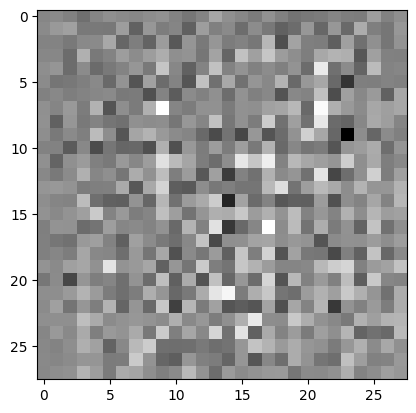

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import cv2
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt

model_recognition = tf.keras.models.load_model('handwrittenRecognition.keras')

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape = [28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
prediction = model_recognition(generated_image)
print("The number is probably a {}".format(np.argmax(prediction)))

